In [15]:
import pandas as pd
import nltk
import numpy as np
import warnings
nltk.download('punkt_tab')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [16]:
df = pd.read_csv('labeledTrainData.tsv', sep='\t')
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [17]:
%%time
def preprocessing(df):
    df['review'] = df.review.str.lower()
    df["document_sentences"] = df.review.str.split('.')
    df['tokenized_sentences'] = list(map(lambda x: list(map(nltk.word_tokenize, x)), df.document_sentences))
    df['tokenized_sentences'] = list(map(lambda x: list(filter(lambda lst: lst, x)), df.tokenized_sentences))
preprocessing(df)

CPU times: user 25 s, sys: 66.3 ms, total: 25.1 s
Wall time: 26.3 s


In [18]:
from sklearn.model_selection import train_test_split
train, test, y_train, y_test = train_test_split(df.drop(columns='sentiment'), df['sentiment'], test_size=0.2)

In [19]:
voc = []
for sen in train.tokenized_sentences:
    voc.extend(sen)
print(f"len voc -> {len(voc)}")
print(f"len train -> {len(train)}")


len voc -> 250078
len train -> 20000


In [20]:
! pip install gensim
import gensim

from gensim.models import Word2Vec, word2vec
num_features = 300
min_word_count = 3
num_workers = 4
context = 8
downsampling = 1e-3

Word2Vec_model = Word2Vec(
    sentences=voc,
    sg=1,
    hs=0,
    workers=num_workers,
    min_count=min_word_count,
    window=context,
    sample=downsampling,
    negative=5,
    vector_size=num_features,
    epochs=6,
)

In [21]:
def sentence_vectors(model, sentences):
    words = np.concatenate(sentences)
    model_vocab = set(model.wv.key_to_index.keys())
    sentence_vector = np.zeros(model.vector_size, dtype=np.float32)
    n_words = 0
    for word in words:
        if word in model_vocab:
            sentence_vector += model.wv[word]
            n_words += 1
    if n_words > 0:
        sentence_vector /= n_words
    return sentence_vector
train['sentence_vector'] = list(map(lambda sen_group: sentence_vectors(Word2Vec_model, sen_group), train.tokenized_sentences))

In [22]:
def vectors_to_feats(df, ndim):
    index = []
    for i in range(ndim):
        df[f'w2v_{i}'] = df['sentence_vector'].apply(lambda x: x[i])
        index.append(f'w2v_{i}')
    return df[index]
X_train = vectors_to_feats(train, num_features)
X_train.head()

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_290,w2v_291,w2v_292,w2v_293,w2v_294,w2v_295,w2v_296,w2v_297,w2v_298,w2v_299
22616,-0.118699,0.113387,0.082199,0.017906,0.043585,-0.143057,0.121375,0.257712,-0.023267,-0.064526,...,0.031697,0.132229,0.099398,-0.029194,0.066888,0.145013,-0.003656,-0.069007,0.009782,0.027030
15872,-0.108883,0.154675,0.102311,-0.035115,0.070507,-0.104243,0.102944,0.269317,-0.005504,-0.047797,...,0.013471,0.149216,0.175592,0.011640,0.119814,0.162143,-0.046551,-0.115188,0.000927,0.041047
17938,-0.113776,0.120908,0.090942,-0.013464,0.024697,-0.148015,0.114637,0.262541,0.045990,-0.034518,...,0.028407,0.128071,0.123284,-0.058755,0.068506,0.143067,0.006185,-0.085072,0.034410,0.039523
22538,-0.120725,0.127117,0.128013,-0.012986,0.048357,-0.126832,0.100618,0.268407,0.025916,-0.040194,...,0.003496,0.144047,0.156063,-0.028698,0.082105,0.130423,-0.010429,-0.057576,0.001959,0.028320
11065,-0.073178,0.149255,0.127566,0.016769,0.069488,-0.122280,0.109056,0.220757,0.011689,-0.045825,...,-0.001587,0.154154,0.173720,0.018689,0.091403,0.143057,-0.037221,-0.071419,0.015359,0.055938


In [23]:
test['sentence_vector'] = list(map(lambda sen_group: sentence_vectors(Word2Vec_model, sen_group), test.tokenized_sentences))
X_test = vectors_to_feats(test, num_features)

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [25]:
from sklearn.metrics import roc_auc_score, confusion_matrix
roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

np.float64(0.9349894484587452)

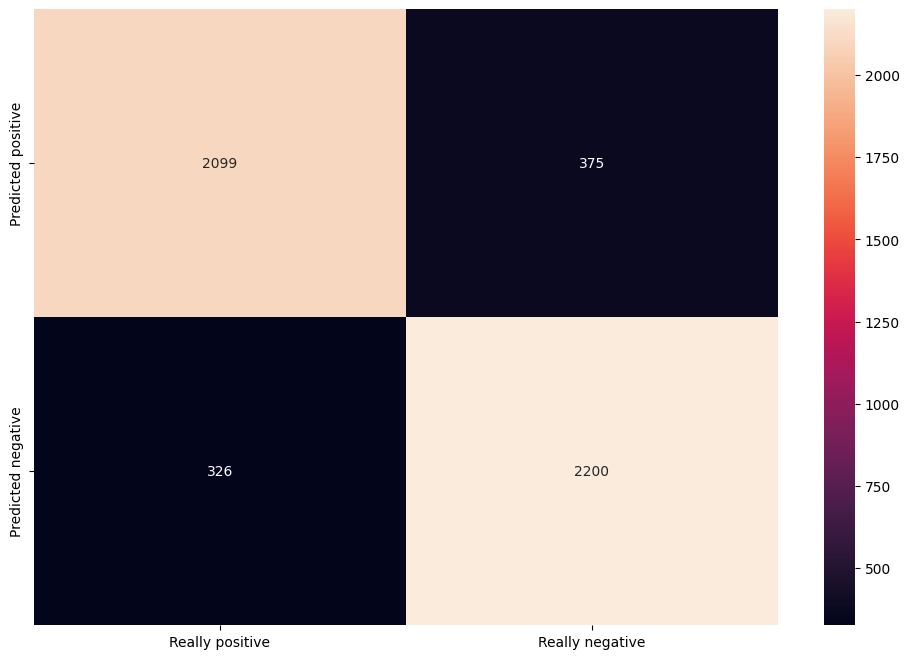

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix(y_test, lr.predict(X_test)),
                     index=["Predicted positive", "Predicted negative"],
                     columns=["Really positive", "Really negative"])
plt.figure(figsize = (12, 8))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [27]:
voc_df = []
for sen in df.tokenized_sentences:
    voc_df.extend(sen)
print(f"len voc_df -> {len(voc_df)}")
print(f"len df -> {len(df)}")


len voc_df -> 313267
len df -> 25000


In [28]:
%%time
Word2Vec_model_df = Word2Vec(
    sentences=voc_df,
    sg=1,
    hs=0,
    workers=num_workers,
    min_count=min_word_count,
    window=context,
    sample=downsampling,
    negative=5,
    vector_size=num_features,
    epochs=6,
)

CPU times: user 9min 52s, sys: 2.11 s, total: 9min 54s
Wall time: 6min 34s


In [29]:
df['sentence_vector'] = list(map(lambda sen: sentence_vectors(Word2Vec_model_df, sen), df.tokenized_sentences))
df = vectors_to_feats(df, num_features)
y = pd.read_csv('labeledTrainData.tsv', sep='\t')['sentiment'].values


In [30]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(df, y)

from sklearn.model_selection import ShuffleSplit, cross_val_score
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
cv_score = cross_val_score(lr, df, y, cv=cv, scoring='roc_auc')
print(f"cv_score -> {cv_score} roc_auc_score -> {cv_score.mean()}, std -> {cv_score.std()}")

cv_score -> [0.94044056 0.94058736 0.94014039 0.93459216 0.94058186 0.93709252
 0.94177002 0.94202841 0.93632773 0.93987904] roc_auc_score -> 0.9393440047891859, std -> 0.0023460565811016785


In [35]:
from nltk.util import pr
def predict_sentiment(review, w2v_model, lr_model):
    review_lower = review.lower()
    sentences = review_lower.split('.')
    review_tokenized = [nltk.word_tokenize(sent) for sent in sentences]
    review_tokenized = [sent for sent in review_tokenized if sent]
    review_vector = sentence_vectors(w2v_model, review_tokenized)
    review_features = review_vector.reshape(1, -1)
    prediction = lr_model.predict(review_features)[0]
    probablity = lr_model.predict_proba(review_features)[0]
    return prediction, probablity

def analyze_review(review):
  prediction, probablity = predict_sentiment(review, Word2Vec_model_df, lr)
  print("="* 70)
  if prediction == 1:
    sentiment = "positive"
  else:
    sentiment = "negative"
  print(f"Sentiment: {sentiment}")
  print(f"Probability: {probablity}")
  print(f"Probability negative: {probablity[0]: .2f}")
  print(f"Probability positive: {probablity[1]: .2f}")
  return prediction, probablity

In [38]:
my_review = "As much as I liked movies like Toy Story and Finding Nemo, it made me curious about other CGI animated movies. I didn't actually see this movie in theaters, but I did rent it and was pleasantly surprised. Not everything is in black and white in this movie, and various stereotypes are broken. And things are not always what they seem. I loved the main characters and they all get my standing ovation. This, along with Wreck-It Ralph and Big Hero 6 are my favorites of the non-Pixar Disney CGI films. If you like anthro animals and want to see them in a somewhat modern setting with no humans, look no further!"
analyze_review(my_review)

Sentiment: positive
Probability: [0.22463754 0.77536246]
Probability negative:  0.22
Probability positive:  0.78


(np.int64(1), array([0.22463754, 0.77536246]))

In [40]:
my_review = """I'm definitely not the biggest Five Nights at Freddy's fan alive. I watched the first movie, didn't like it, but I could at least understand why some people enjoyed it.

With the second one? Man... I genuinely have no idea how anyone walks out of this thinking, "Yeah, that was good."

This thing is basically a fan-service piñata that someone slapped together with the energy of a dying WiFi router. Sure, the animatronics look great (honestly the only part of the production where it feels like effort was involved). Marionette in particular could've been genuinely creepy... if they didn't spend most of the movie turning her into a goofy possession gimmick with cartoon eyes and wet-noodle arms. Completely wasted potential at this point...

Yes, the movie is bigger than the first one. More robots, more locations, more noise. Great.

But it doesn't matter when the whole script collapses like a folding table at a frat party.

Now the rest... and this is where the mountain of issues starts:

The writing is awful.

Characters talk like they were written on a crumpled napkin. The plot relies entirely on braindead coincidences...

Example: A car breaks down in the middle of nowhere, in the dead of night... and suddenly a friend just happens to drive by, doesn't question anything, and gives a ride. Sure. Totally normal.

People appear out of nowhere like they mastered instant transmission, and a supposedly abandoned, forgotten-for-decades location apparently sits right next door to everyone. Nobody in this world seems to need more than 90 seconds to travel miles.

And the story: Just as bad.

The villain's motivation could have been good, but it's executed so bizarrely that you can't take it seriously. No adult on earth would react that dismissively to a kid shouting about a kidnapping. In this movie, the parents treat her like she said aliens stole her homework. It's absurd and breaks the whole setup.

Then there's the big, hyped-up Fazbear Festival. Posters everywhere, constant mentions, obvious build-up toward some big showdown... And then it amounts to absolutely nothing. It never matters. At all.

The final battle happens in a single cramped room like they ran out of money halfway through shooting. Why even include the festival if it's not going to matter? Feels like a huge missed opportunity, maybe a budget problem, who knows.

The horror is basically just loud noises and jump-cuts with zero buildup. No tension, no atmosphere, nothing memorable. It's kiddie horror - which would be fine if the rest of the movie could carry the weight... It doesn't.

The dynamic between Mike and Vanessa is also baffling. Vanessa carries the whole movie, protects his sister, does all the heavy lifting, and Mike reacts like she personally keyed his car. Zero emotional logic.

And the biggest problem of all: This isn't a movie. It's a two-hour setup for the third one.

Nothing gets resolved.

There's no real climax.

No sense of completion.

It's like reading a book where the author ends chapter eight with "To be continued..." and just walks away.

FNaF fans will probably love this movie anyway, because it shows them the stuff they already adore from the games. And hey, that's fine, the fanservice is overflowing.

But as a standalone film? It's weak. Really weak.

It feels like a two-hour trailer for Part 3 with some cool animatronics sprinkled in.

If you're expecting an ACTUAL film with pacing, logic, or coherent writing...

Yeah, this ain't it. Not even close"""
analyze_review(my_review)

Sentiment: negative
Probability: [0.94474876 0.05525124]
Probability negative:  0.94
Probability positive:  0.06


(np.int64(0), array([0.94474876, 0.05525124]))

In [41]:
next_review = """I never really leave many reviews on this app but I HAD to for this. I'm an old fan of the franchise I know a lot of the lore and have watched 100s of hours of content on this game series. I left the first movie saying that was dumb fun, yeah it's kind of a bad movie but I was able to turn my brain off and have fun. With all this in mind this movie is absolute GARBAGE. It has an incoherent plot with GAPING holes. It is not the least bit scary. Any attempt to make it scary fell flat on its face. It has some of the WORST dialogue I've ever heard and overall it just feels like they didn't care. The movie treats the audience as if they're toddlers I couldn't believe it was rated 15s. I will say I had fun with this movie but only because me and the rest of the audience members were cackling at the movie, not with it AT IT. I genuinely will say I would recommend going to see this movie with your mates(preferably drunk) and just have fun at how awful this movie is. I will absolutely watch the next one. Not cause I think it will be good but just to see if it can get even worse."""
analyze_review(next_review)

Sentiment: negative
Probability: [0.89335483 0.10664517]
Probability negative:  0.89
Probability positive:  0.11


(np.int64(0), array([0.89335483, 0.10664517]))

In [42]:
analyze_review("What Can I say, in my opinion it was WAY better than the first one. Great cast as always, great effects, great animatronics. It's was what fans had hoped for. They cranked up on the sound effects we as fans know and love. I love this community. Great acting honestly all of them 10/10 the only reason I give it 9/10 is because it's not lore as in the games but IT WAS GREAT!!! Watch beyond credits there is an extra scene")

Sentiment: positive
Probability: [0.02228873 0.97771127]
Probability negative:  0.02
Probability positive:  0.98


(np.int64(1), array([0.02228873, 0.97771127]))